# Lab: Logistic Regression
## CMSE 381 - Fall 2023
## Sep 20, 2023



In this module we are going to test out the logistic regression classification method we discussed in class 

## Getting a feel for the data

We're going to use the `Smarket` data set from the ISLR book as included in their R package.  I've included a csv in the [DataSets folder](../../Datasets) for you to use. 

This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, `Lag1` through `Lag5`. We have also recorded `Volume` (the number of shares traded on the previous day, in billions), `Today` (the percentage return on the date in question) and `Direction` (whether the market was `Up` or `Down` on this date). Our goal is to predict `Direction` (a qualitative response) using the other features.

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
import seaborn as sns

In [6]:
smarket = pd.read_csv('Smarket.csv', index_col = 0)

In [7]:
smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1246,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1247,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1248,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1249,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


Note that the `Year` column only has the year information.  In the case of this data, the sorted order tracks the days, so be sure to not accidentally shuffle it! 

In particular, if you try to plot it like this, you kinda get  garbage because you just have a bunch of year data vertically and no time series

<Axes: xlabel='Year'>

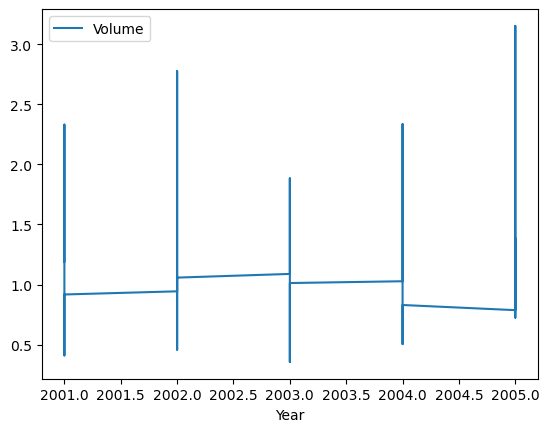

In [8]:
smarket.plot(x = 'Year', y='Volume')

This is better, but you don't really get to see the x-axis with nice labels

<Axes: >

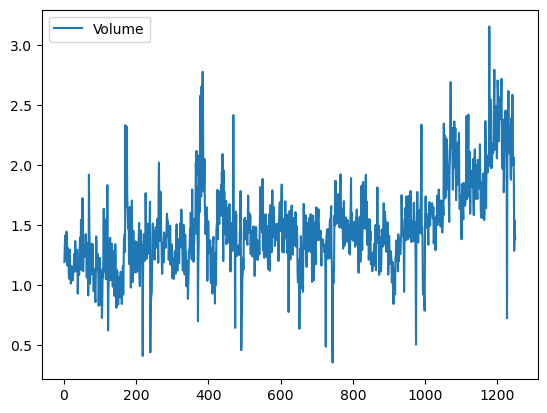

In [9]:
smarket.plot(y = 'Volume')

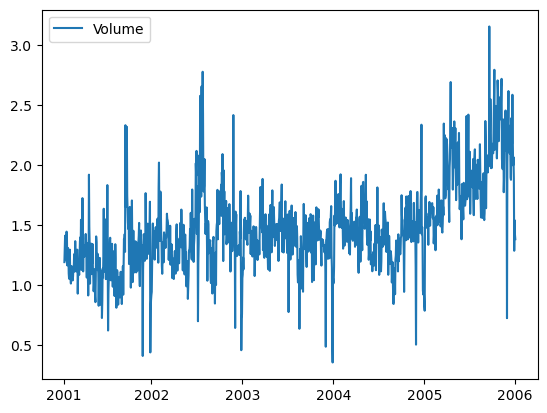

In [10]:
# So here's some hacky code so I can actually see the years on my plot

# Where do the years start? 
years = np.arange(2001,2007)
yearIndex = []
for year in years[:-1]:
    start = np.where(smarket.Year == year)[0][0]
    yearIndex.append(start)
yearIndex.append(smarket.shape[0]-1)

# Plot the volume, but relabel the x-axis with the years
smarket.plot(y='Volume')
ax = plt.gca()
ax.set_xticks(yearIndex, years);


&#9989; **<font color=red>Do this:</font>** Write a brief description of the data set. Which of the available variables are quantitative? Which are categorical? Draw some plots of the data and get a feel for what the columns mean. 

The data set, named Smarket, consists of financial data from the S&P 500 stock index, recorded daily over approximately 1,250 days from 2001 to 2005. It contains information on daily percentage returns from the previous five days (Lag1 through Lag5), the trading Volume in billions of shares, the Year, the percentage return on the current day (Today), and a categorical variable Direction indicating whether the market was "Up" or "Down" on each particular day.

Quantitative Variables: Lag1, Lag2, Lag3, Lag4, Lag5, Volume, Today, Year

Categorical Variable: Direction (Up or Down)

   Year   Lag1   Lag2   Lag3   Lag4   Lag5  Volume  Today Direction
1  2001  0.381 -0.192 -2.624 -1.055  5.010  1.1913  0.959        Up
2  2001  0.959  0.381 -0.192 -2.624 -1.055  1.2965  1.032        Up
3  2001  1.032  0.959  0.381 -0.192 -2.624  1.4112 -0.623      Down
4  2001 -0.623  1.032  0.959  0.381 -0.192  1.2760  0.614        Up
5  2001  0.614 -0.623  1.032  0.959  0.381  1.2057  0.213        Up
              Year         Lag1         Lag2         Lag3         Lag4  \
count  1250.000000  1250.000000  1250.000000  1250.000000  1250.000000   
mean   2003.016000     0.003834     0.003919     0.001716     0.001636   
std       1.409018     1.136299     1.136280     1.138703     1.138774   
min    2001.000000    -4.922000    -4.922000    -4.922000    -4.922000   
25%    2002.000000    -0.639500    -0.639500    -0.640000    -0.640000   
50%    2003.000000     0.039000     0.039000     0.038500     0.038500   
75%    2004.000000     0.596750     0.596750     0.596750     0.596750   


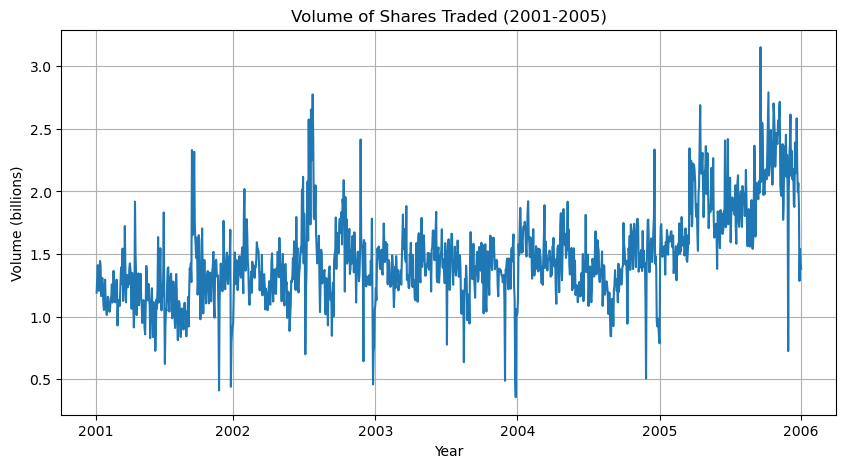

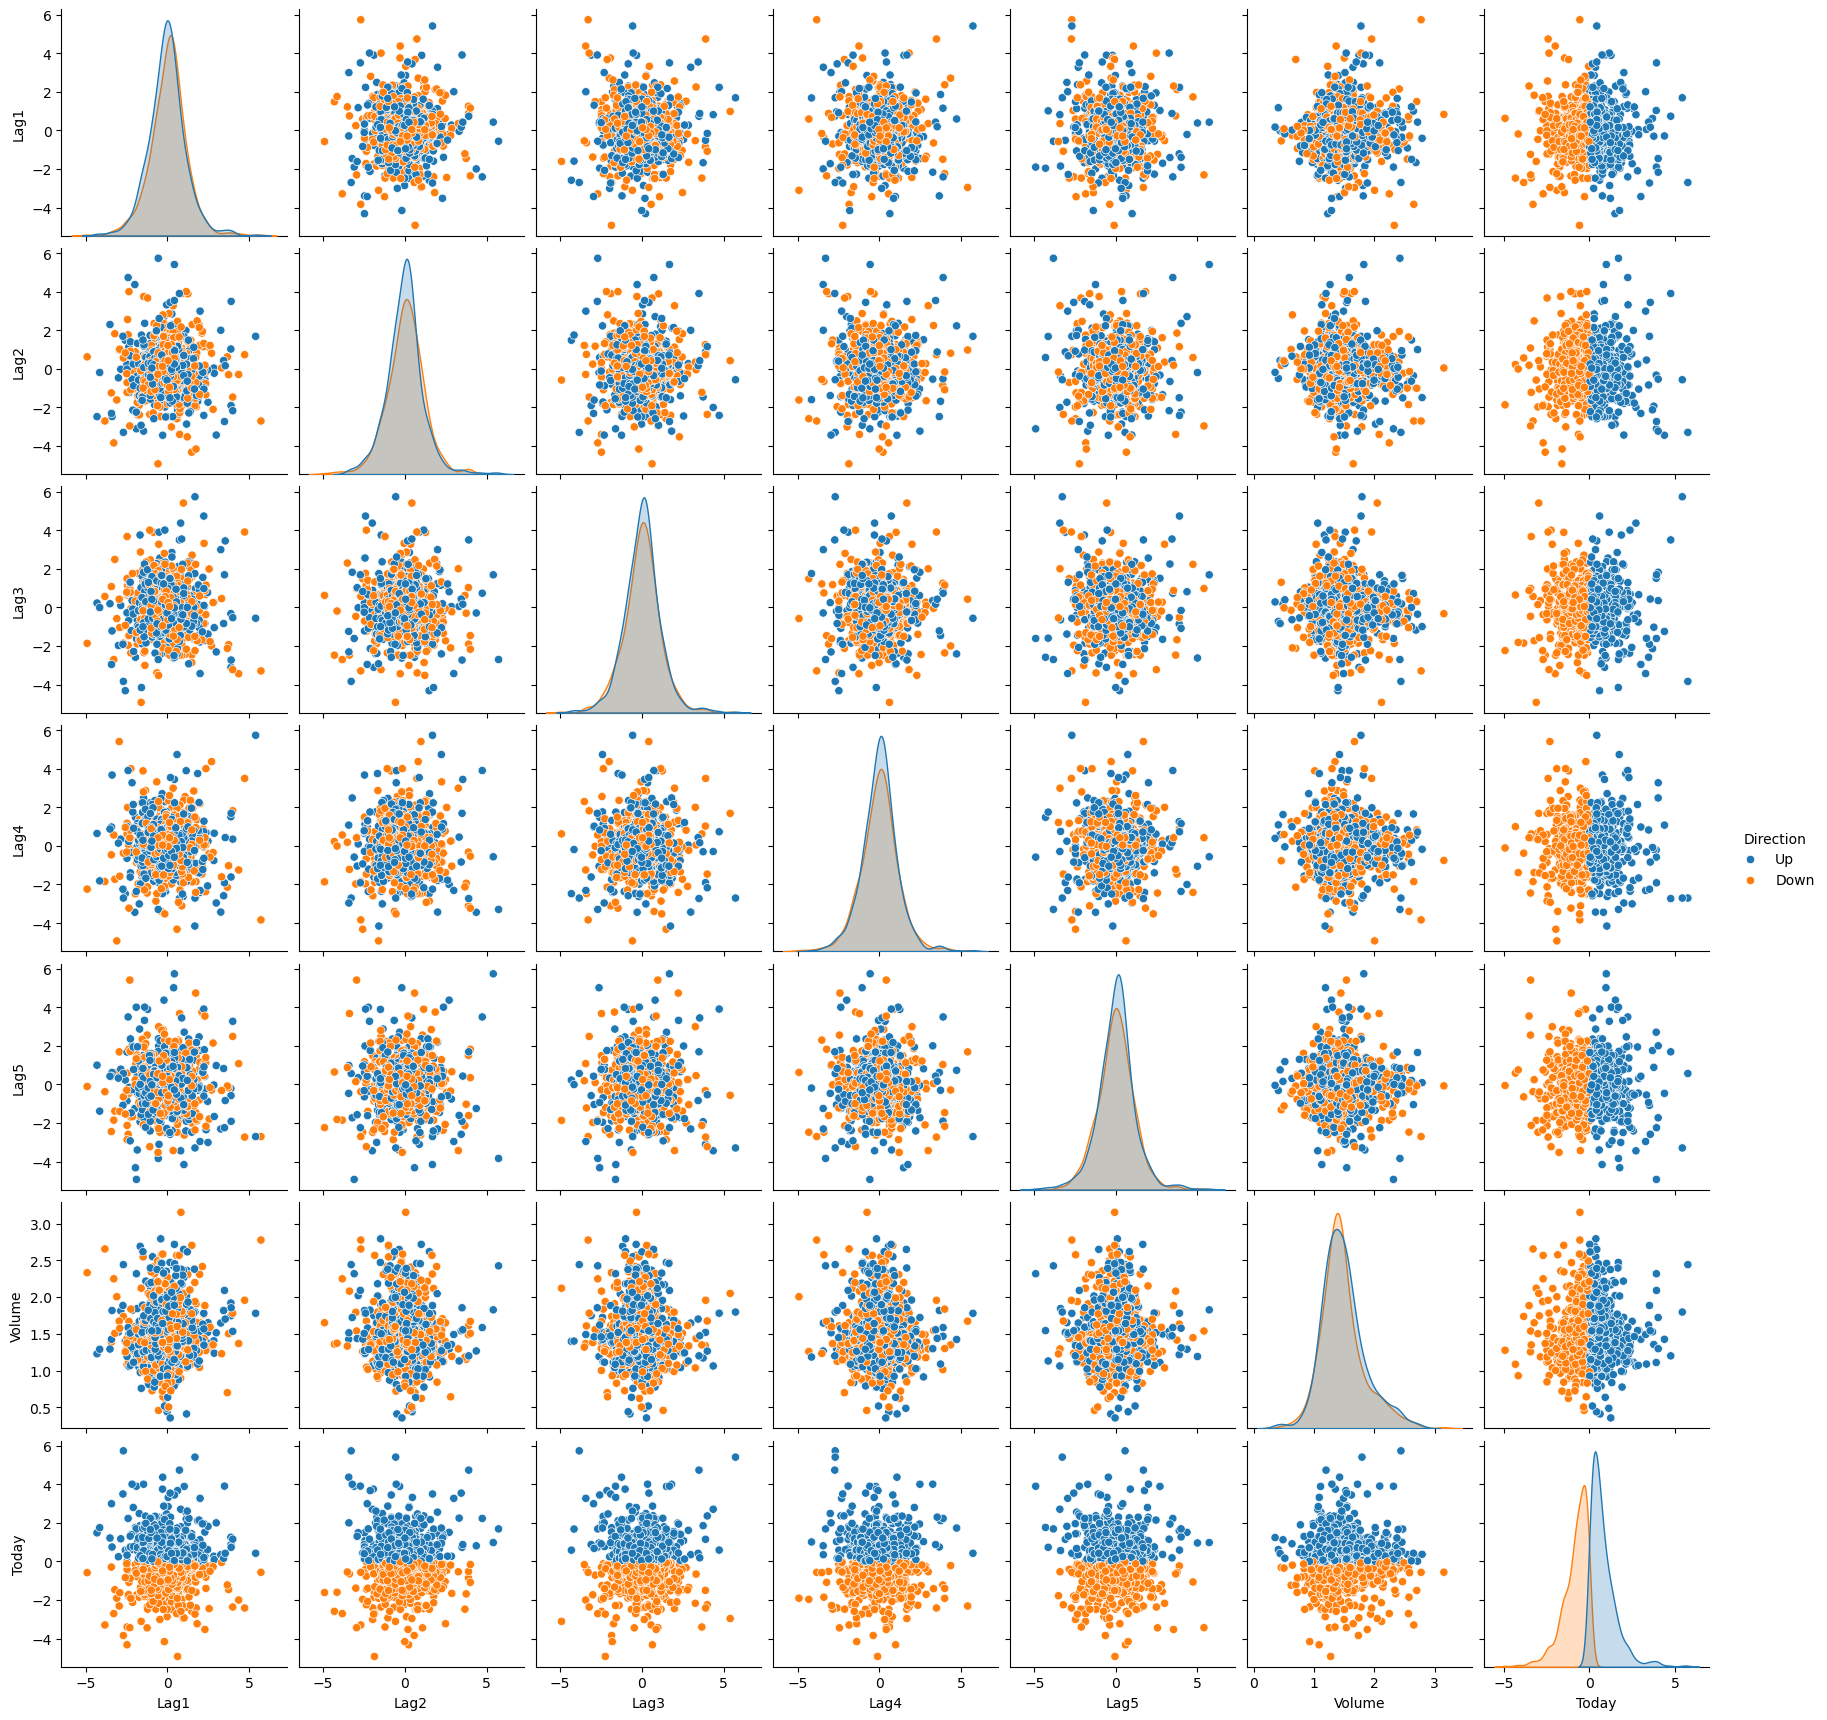

In [12]:
smarket = pd.read_csv('Smarket.csv', index_col=0)

print(smarket.head())

print(smarket.describe())

years = [2001, 2002, 2003, 2004, 2005, 2006]
year_ticks = [0] + [smarket[smarket['Year']==y].index[0] for y in years[1:-1]] + [len(smarket)-1]

plt.figure(figsize=(10,5))
plt.plot(smarket['Volume'])
plt.xticks(year_ticks, years)
plt.xlabel('Year')
plt.ylabel('Volume (billions)')
plt.title('Volume of Shares Traded (2001-2005)')
plt.grid(True)
plt.show()

sns.pairplot(smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction']], 
             hue='Direction', diag_kind='kde')
plt.show()

&#9989; **<font color=red>Do this:</font>** Take a look at the correlation matrix, which can be found with `dataframe.corr()`. Does it include all of the variables in the data set? What do you notice about the correlations?

*Hint: A great way to see what's going on with a correlation matrix is to use the `plt.matshow` or `sns.heatmap` command.*

            Year      Lag1      Lag2      Lag3      Lag4      Lag5    Volume  \
Year    1.000000  0.029700  0.030596  0.033195  0.035689  0.029788  0.539006   
Lag1    0.029700  1.000000 -0.026294 -0.010803 -0.002986 -0.005675  0.040910   
Lag2    0.030596 -0.026294  1.000000 -0.025897 -0.010854 -0.003558 -0.043383   
Lag3    0.033195 -0.010803 -0.025897  1.000000 -0.024051 -0.018808 -0.041824   
Lag4    0.035689 -0.002986 -0.010854 -0.024051  1.000000 -0.027084 -0.048414   
Lag5    0.029788 -0.005675 -0.003558 -0.018808 -0.027084  1.000000 -0.022002   
Volume  0.539006  0.040910 -0.043383 -0.041824 -0.048414 -0.022002  1.000000   
Today   0.030095 -0.026155 -0.010250 -0.002448 -0.006900 -0.034860  0.014592   

           Today  
Year    0.030095  
Lag1   -0.026155  
Lag2   -0.010250  
Lag3   -0.002448  
Lag4   -0.006900  
Lag5   -0.034860  
Volume  0.014592  
Today   1.000000  


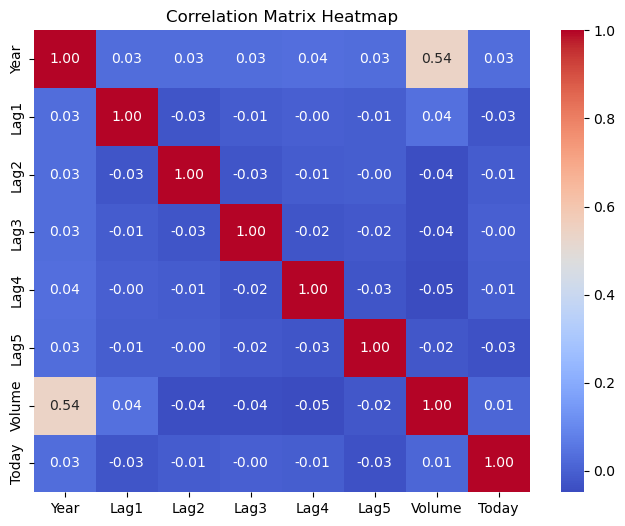

In [14]:
numeric_cols = smarket.select_dtypes(include=['number'])

corr_matrix = numeric_cols.corr()
print(corr_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix does not include the categorical variable (Direction), only quantitative variables. The correlations between variables (Lag1 to Lag5, Volume, Today) are generally very low, close to zero, indicating minimal linear relationships.

&#9989; **<font color=red>Q:</font>** Do some further investigation on the high correlation value you saw in the previous step. Can you justify why that particular pair of variables has a high correlation? 

The high correlation (0.54) is between Year and Volume. This likely indicates that trading volume gradually increased over the years, reflecting a market trend of increasing participation or activity over time. Thus, the correlation is due to a natural temporal increase rather than a causal relationship.

## Classification using Logistic Regression

Our goal is to predict `Direction`, a categorical variable taking as values the strings `Up` and `Down`.


For this module, we will largely use the tools from `sklearn`  for classification. One of the big perks of the `sklearn` module is that there is a great deal of uniformity in the classes. So once we have a handle on how to interact with one kind of classification tool, very minor tweaks in the code will allow for the use of a new model. In fact, many of the things we'll do today should look very similar in terms of the syntax to the linear regression lab from a few weeks ago. 

For our first try doing classification, we'll use `LogisticRegression` from the `sklearn.linear_model` module. I'm a huge fan of the `sklean` documentaiton since it includes a great deal of info on the math behind what we're doing as well as explanations on the code:
- [`sklearn` mathematical description of logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
- [`LogisticRegression` class documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)

In [15]:
from sklearn.linear_model import LogisticRegression 

Lets first predict `Direction` using `Lag1`,`Lag2` and `Volume`. 
Our first job is to extract the portion of the dataframe that we want to use. `sklearn` is happiest when we hand it an array. 

In [16]:
X = smarket[['Lag1','Lag2','Volume']]
Y = smarket.Direction

In [17]:
print(X.shape)
print(Y.shape)

(1250, 3)
(1250,)


Once we have our data, we create an instance of the model class we want, in this case `LogisticRegression`, and fit the model to the data. Note the `random_state=0` code ensures that rerunning the following box will return the same answer every time. 

In [18]:
clf = LogisticRegression(random_state=0)
clf.fit(X,Y)

LogisticRegression(random_state=0)

Great, that was easy! Once we've fit the model, the main task is to understand how to extract information from it. 

&#9989; **<font color=red>Do this:</font>** Extract the coefficients and intercept from the trained model.  What is the equation, in terms of the variables used, that you are modeling? 

*(Hint: You might need to take a look at the documentation to figure out how get the coefficients and intercepts, but you should notice that `sklearn` has a pattern as to how it does this.)*

In [19]:
intercept = clf.intercept_[0]
coefficients = clf.coef_[0]

print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: -0.11655585054417365
Coefficients: [-0.07311603 -0.04274018  0.12907482]


While it's good to know what equation we're modeling with, the big perk here is that your `sklearn` class will evaluate the data points of your model for you. Yay!

&#9989; **<font color=red>Do this:</font>** Use the `predict_proba` function to determine the probabilities $Pr(Y = \texttt{Down} \mid X)$ for the data set. What shape is the output matrix? Why that shape? What do the columns represent?

In [20]:
probs = clf.predict_proba(X)

print("Shape:", probs.shape)
print(probs[:5])

Shape: (1250, 2)
[[0.49561014 0.50438986]
 [0.50890222 0.49109778]
 [0.51270952 0.48729048]
 [0.48760578 0.51239422]
 [0.4947993  0.5052007 ]]


Of course this gives us the probability of each each label for a given data, but we really would like to have the prediction itself. 


&#9989; **<font color=red>Do this:</font>** Use the `predict` function to determine the predictions for each input data point in the original $X$ matrix and store the output as `Yhat`. How many predictions are different than the actual `Direction` value? Whats the percent error for the model?

In [21]:
Yhat = clf.predict(X)

num_wrong = (Yhat != Y).sum()
percent_error = num_wrong / len(Y) * 100

print("Number of incorrect predictions:", num_wrong)
print("Percent error:", round(percent_error, 2), "%")

Number of incorrect predictions: 583
Percent error: 46.64 %



&#9989; **<font color=red>Do this:</font>** An even easier way of figuring out the error rate is through the score. What does the output of `clf.score(X,Y)` mean and how is it related to the number you determined above?

In [23]:
accuracy = clf.score(X, Y)
print("Accuracy:", round(accuracy, 4))

error_rate = 1 - accuracy
print("Error Rate:", round(error_rate, 4))

Accuracy: 0.5336
Error Rate: 0.4664


**Confusion matrix**

As we saw in class, the percent error is a rather limited way of evaluating the classification model. Luckily `sklearn` provides commands for computing the confusion matrix for a given model easily. The `confusion_matrix` command computes the confusion matrix, and `ConfusionMatrixDisplay` gives a nice visual representation. 

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
# This code gives the confusion matrix, assuming you stored the predicted values as `Yhat`.
C = confusion_matrix(Y,Yhat)

C

array([[147, 455],
       [128, 520]])

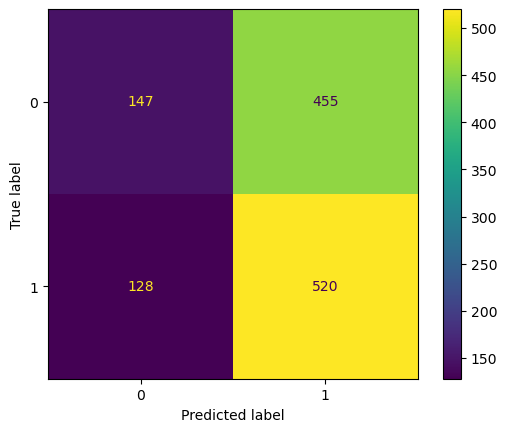

In [26]:
# This code gives a visual representation 
ConfusionMatrixDisplay(C).plot()


&#9989; **<font color=red>Q:</font>** The makers of `sklearn` made a PARTICULARY strange choice when it comes to the confusion matrix representation.  What is different about the `sklearn` confusion matrix from how we saw it in class?

sklearn shows true labels on rows and predicted labels on columns, which is opposite from how it's usually shown in class.



-----
### Congratulations, we're done!
Written by Dr. Liz Munch, Michigan State University

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.